In [135]:
import numpy as np 
import pandas as pd 
import os

import pydicom
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from os import listdir
import collections
import cv2
from PIL import Image
import matplotlib.image as mpimg
import glob
import time

#import pytorch libraries for CNN
import torch
# data loading and transforming
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

#use GPU if possible
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#metrics
from sklearn.metrics import accuracy_score,f1_score

In [136]:

dftrain1=pd.read_csv( "train_50a.csv")

toy=pd.read_csv( "train_all.csv")
#As example of evaluation of some images included in the project
val_toy=toy[:8]

In [137]:
val_toy.tail()

,Unnamed: 0,id,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
3,3,ID_0000950d7,0,0,0,0,0,0
4,4,ID_0000aee4b,0,0,0,0,0,0
5,5,ID_0000f1657,0,0,0,0,0,0
6,6,ID_000178e76,0,0,0,0,0,0
7,7,ID_00019828f,0,0,0,0,0,0


In [138]:
data=val_toy.copy()
data.set_index("id", inplace=True)
data.loc['ID_00005679d']

Unnamed: 0          1
any                 0
epidural            0
intraparenchymal    0
intraventricular    0
subarachnoid        0
subdural            0
Name: ID_00005679d, dtype: int64

In [139]:
#the complete collection of files (images in png format) are in Kaggle - owner is Tom Aindow-
#https://www.kaggle.com/taindow/pytorch-efficientnet-b0-benchmark

#correction of files containing ilegitimate images 
#subset of images for validation purposes
dir_img='png_examples2'
png = glob.glob(os.path.join(dir_img, '*.png'))
png = [os.path.basename(png)[:-4] for png in png]
png = np.array(png)

dfval = val_toy[val_toy['id'].isin(png)]
dfval=dfval.reset_index()
dfval.head()

,index,Unnamed: 0,id,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,4,4,ID_0000aee4b,0,0,0,0,0,0
1,5,5,ID_0000f1657,0,0,0,0,0,0


In [140]:
dfval.shape

(2, 9)

In [141]:
#3-channels were substitute for an image composition: 1- original crop image,2-  bright/contrast adjustment, 3-gaussian blur


def crop_image_from_gray_mod(image_path,tol=0):
    #return a 3-channel image
    img= cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray_img>tol
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0): # image is too dark so that we crop out everything,
        return img # return original image
    else:
        img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
        img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
        img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        image = np.stack([img1,img2,img3],axis=-1)
    return image


def adjusting_cb (image, alpha=3, beta=0):
    adjusted= cv2. convertScaleAbs(image, alpha=alpha, beta=beta)
    gray_adjusted = cv2.cvtColor(adjusted, cv2.COLOR_RGB2GRAY)   
    return gray_adjusted

#blur the image and normalize the image 
def blur (gray_image):
    gray_blur=cv2.GaussianBlur(gray_image, (5,5),0)    
    return gray_blur

#normalize one channel image
def normalize(gray_image):    
    mean,std=cv2.meanStdDev(gray_image)
    image_norm=(gray_image-mean)/std
    return image_norm

def compose_image(image_path):
    image=cv2. imread(image_path) #1
    crop_image=crop_image_from_gray_mod(image_path,tol=0)#2
    gray_image=crop_image[:,:,0] #3    
    adjust_img=adjusting_cb (crop_image, alpha=3, beta=0)#5
    blur_img=blur(gray_image)#6    
    img1=gray_image
    img2=adjust_img
    img3=blur_img
    image = np.stack([img1,img2,img3],axis=-1)    
    return image

def compose_image2(image_path):
    image=cv2. imread(image_path) #1
    crop_image=crop_image_from_gray_mod(image_path,tol=0)#2
    gray_image=crop_image[:,:,0] #3
    gray_norm=normalize(gray_image)#4
    adjust_img=adjusting_cb (crop_image, alpha=3, beta=80)#5
    blur_img=blur (gray_image)#6
    
    img1=gray_norm
    img2=adjust_img
    img3=blur_img
    image = np.stack([img1,img2,img3],axis=-1)
    
    return img1,img2,img3

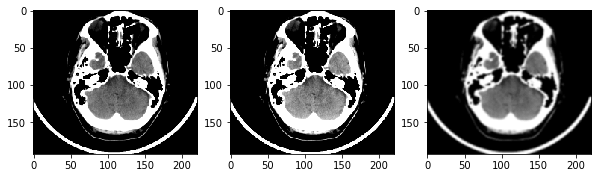

In [142]:
path='png_examples2/'

image_path=path+'ID_0002a616e.png'

img1,img2,img3=compose_image2(image_path)
f, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
ax1.imshow(img1,cmap='gray')
ax2.imshow(img2,cmap='gray')
ax3.imshow(img3,cmap='gray')

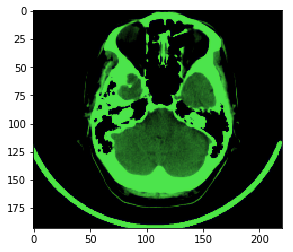

In [143]:
#example

c_image=compose_image(image_path)
plt.imshow(c_image, cmap='gray')

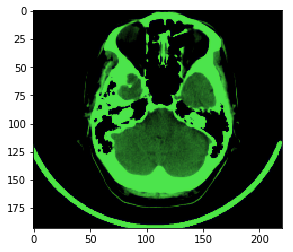

In [144]:
#pil_image = Image.fromarray((c_image*255).astype(np.uint8))
pil_image = Image.fromarray((c_image))
plt.imshow(c_image, cmap='gray')

In [145]:
class BrainDataset4(Dataset):
    
    def __init__(self,df,path,transform=None):
        self.df = df
        self.path= path
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        image_path = os.path.join(self.path,self.df.loc[idx, 'id'] + '.png')
        #open, crop and compose a 3channel-array normalized(gray, adjust, blur)
        c_image= compose_image(image_path)
        
        #convert to PIL X image, y label 'any'      
        X=Image.fromarray(c_image)      
        y = torch.tensor(self.df.loc[idx, ['epidural', 'intraparenchymal', 'intraventricular','subarachnoid', 'subdural', 'any']])
        if self.transform:
            X=self.transform(X)        
        return X,y

In [146]:
#transforms
train_transform = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ColorJitter(brightness=0.05, contrast=0.08, hue=0),transforms.RandomRotation(degrees=30),
                                      transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


test_transform= transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#datasets -
#original path in kaggle
#path='../input/rsna-train-stage-1-images-png-224x/stage_1_train_png_224x'
train_dataset = BrainDataset4(df=dftrain1,path=path,transform=train_transform)

val_dataset=BrainDataset4(df=val_toy,path=path,transform=test_transform)

#loaders
#batch_size=32
batch_size=2
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers=2, shuffle=True)
val_loader=torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,num_workers=0,shuffle=False)

In [147]:
model= models.resnext50_32x4d(pretrained=True)
#model.load_state_dict(torch.load("../input/pretrained-pytorch/resnext50_32x4d-7cdf4587.pth",map_location='cpu'))
#model.load_state_dict(torch.load("../input/pretrained-pytorch/resnext50_32x4d-7cdf4587.pth"))
for p in model.parameters():
#p.requires_grad = False
    p.requires_grad = True
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)
#the file with weigths ('trained_model.pt') is too big and it was not possible to upload. 
#Substitute with a trained model
#model.load_state_dict(torch.load('trained_model.pt',map_location='cpu'))
#model.load_state_dict(torch.load('trained_model.pt'))
learning_rate = 0.0001# I started with learning_rate=0.001
class_weight = torch.FloatTensor([1.0, 0.3, 0.3, 0.5, 0.5, 0.2])
class_weight=class_weight.to(device)
criterion = torch.nn.MultiLabelSoftMarginLoss(weight=class_weight)
optimizer=optim.Adam(model.parameters(), lr=learning_rate)


In [148]:
def train_clas(data_loader, model, criterion, optimizer, num_epochs, name_last):    
    train_losses = []
    for epoch in range(num_epochs):
        model.train().to(device)
        running_loss = 0.0
        for batch_i, data in enumerate(data_loader):
            start=time.time()
            inputs,labels=data
            inputs=inputs.to(device)
        #print (inputs)
            labels=labels.to(device, dtype=torch.float)
        #zero the parameter gradient
            optimizer.zero_grad()
        #forward pass
            outputs=model(inputs)            
            loss=criterion(outputs,labels)
        #backward pass to calculate weight gradients
            loss.backward()
        #update the weights
            optimizer.step()        
            running_loss +=loss.item()
            
        dataset_size=len(data_loader.dataset)
        epoch_loss = running_loss / dataset_size
        print('epoch: {},Loss: {:.4f} '.format(epoch,epoch_loss))
#keep the data in a list for model evaluation purposes
        train_losses.append(epoch_loss)
# train_accuracy.append(epoch_acc)
        end=time.time()
        print( "Made 1 epoch training in {:.4f} seconds.".format(end - start))
    last_model_wts = model.state_dict()
    torch.save(last_model_wts,name_last)
    return train_losses
print ('done2')

done2


In [149]:
#f1 score of each subtype
def evaluate(model, val_loader):
    all_preds = []
    true = []
    model.eval()
    for b in val_loader:
        X, y = b
        #if torch.cuda.is_available():
            #X, y = X.cuda(), y.cuda()
        output = model(X)
        #all_preds.append(pred.sigmoid().cpu().data.numpy())
        pred=torch.round(output.sigmoid())
        all_preds.append(pred.data.numpy().astype(int))        
       # true.append(y.cpu().data.numpy())
        true.append(y.data.numpy())
        
    P = np.concatenate(all_preds)    
    R = np.concatenate(true)
    
    #f1 = f1_score(R, P,labels=[0,1,2,3,4,5],average=None)
    total = len(P) 
    print ('Number of samples: ',total)
    
    accuracy_s=accuracy_score(R,P)     
    return 'Accuracy:',accuracy_s



In [150]:
#1st training as example

num_epochs=1
name_last='trained_model.pt'
#train_losses=train_clas(train_loader, model, criterion, optimizer, num_epochs,name_last)

In [151]:
#evaluate(model, val_loader)